# 01. Setup

## 01.01. Install Packages & Prerequisites

In [4]:
# Install packages & prerequisites
!pip install pyro-ppl
!pip install pyldavis
!pip install seaborn
!pip install nltk
!pip install spacy
!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 28.0 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


## 01.02. Load Preprocessing Files

## 01.03. Import Packages

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import linear_model
import seaborn as sns

import torch
from torch import nn
from torch.distributions import constraints
import functools

import pyro
import pyro.distributions as dist
from pyro.optim import Adam, ClippedAdam
from pyro.infer import MCMC, NUTS, HMC, SVI, Trace_ELBO, JitTraceEnum_ELBO, TraceEnum_ELBO, TraceMeanField_ELBO
from pyro.contrib.autoguide import AutoDiagonalNormal, AutoMultivariateNormal, AutoGuideList, AutoDelta

import gensim
import pyLDAvis
import pyLDAvis.gensim_models as pyldagensim

# fix random generator seed (for reproducibility of results)
np.random.seed(42)

# matplotlib style options
plt.style.use('ggplot')
%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 8)

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

# to collect the accuracies of all  the models
accuracies = []

# 02. Prepare Initial Datatset

## 02.01. Load Preprocessed Data

Preprocessing the Enron dataset to model individuals, their emails and preprocess the body of each email is a time consuming process. So this process has already been done and the results are saved as object files which need to be loaded here.

In [128]:
import pandas as pd

# load csv
df = pd.read_csv('Data_Train_AllNumbers.csv')
df.head()

,GGGrade,Validation,Yearly_Income,Home_Status,Lend_Amount,Deprecatory_Records,Interest_Charged,Inquiries,Present_Balance,Gross_Collection,Sub_GGGrade,State,Duration,Unpaid_Amount,Reason,Due_Fee,Default
0,1,0,123200,0,10260,0,18.94,0,175923,0,11,0,3,6970,12,0.0,0
1,1,0,255200,2,27916,0,13.27,1,628237,0,13,0,3,17461,12,0.0,1
2,2,2,98842,1,14535,0,15.84,0,66999,0,20,0,3,0,12,0.0,0
3,2,0,149600,0,6840,0,21.80,0,471337,0,19,0,3,7278,12,0.0,0
4,2,0,70400,0,10260,0,20.11,0,166497,0,20,0,3,12967,12,0.0,0


## 02.02. Adding Features

We divide the home status and the duration into bins and we add the resulting features to the dataframe.

In [129]:
# we divide between status for home status bins

# group 0
zero = df.loc[(df['Home_Status'] == 0)]
d_zero = zero.loc[df['Default'] == 1]
df['Home0'] = (df['Home_Status'] == 0)
df['Home0'] = df['Home_Status'].astype(int)

# group 1
one = df.loc[(df['Home_Status'] == 1)]
d_one = one.loc[df['Default'] == 1]
df['Home1'] = (df['Home_Status'] == 0)
df['Home1'] = df['Home_Status'].astype(int)

# group 2
two = df.loc[(df['Home_Status'] == 2)]
d_two = two.loc[df['Default'] == 1]
df['Home2'] = (df['Home_Status'] == 0)
df['Home2'] = df['Home_Status'].astype(int)

# group 3
three = df.loc[(df['Home_Status'] == 3)]
d_three = three.loc[df['Default'] == 1]
df['Home3'] = (df['Home_Status'] == 0)
df['Home3'] = df['Home_Status'].astype(int)

# group 4
four = df.loc[(df['Home_Status'] == 4)]
d_four = four.loc[df['Default'] == 1]
df['Home4'] = (df['Home_Status'] == 0)
df['Home4'] = df['Home_Status'].astype(int)

In [130]:
assert sum([len(zero), len(one), len(two), len(three), len(four)]) == len(df)

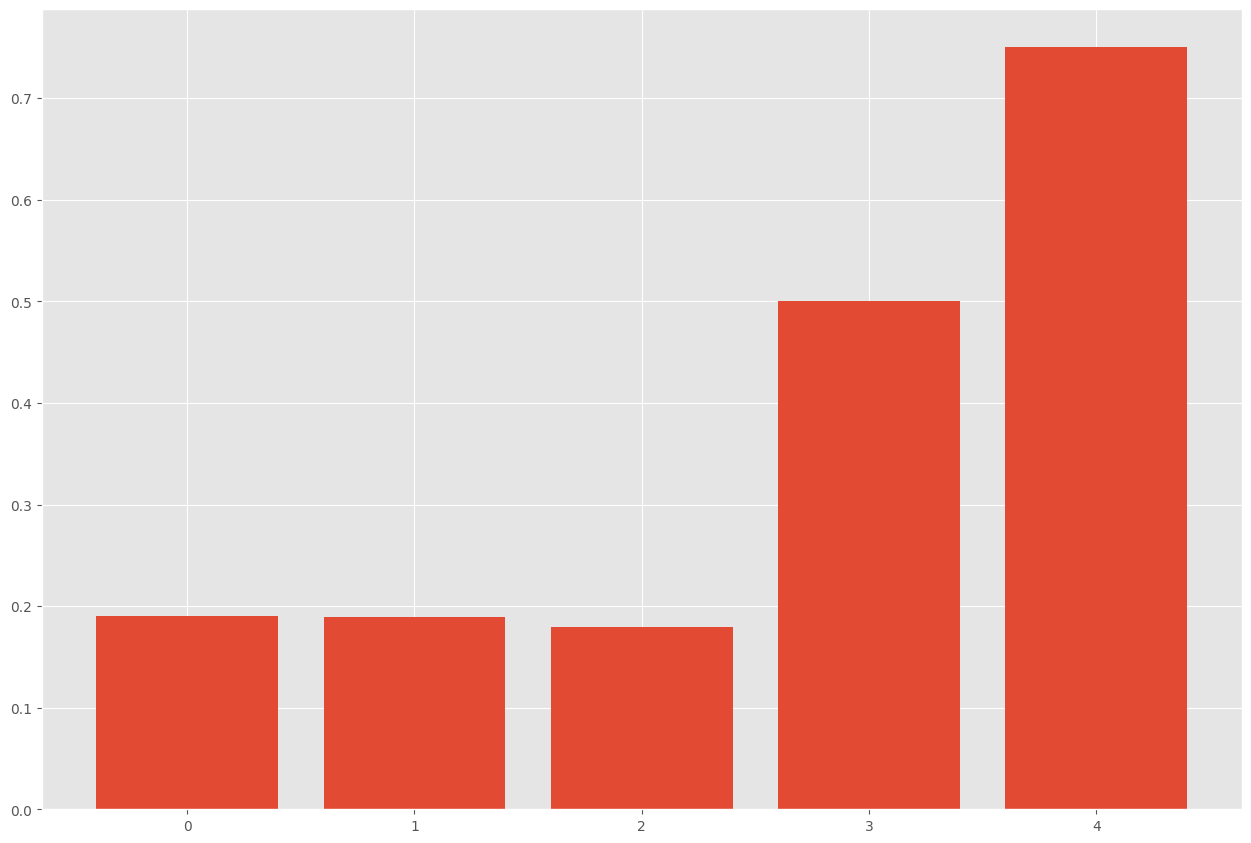

In [131]:
# plotting the fraction of deleted emails for various body lengths
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
lengths = ['0', '1', '2', '3', '4']
deleted_fractions = [len(d_zero)/len(zero),  len(d_one)/len(one), len(d_two)/len(two), len(d_three)/len(three),
            len(d_four)/len(four)]
ax.bar(lengths, deleted_fractions)
plt.show()

In [132]:
# we divide subject duration into bins

# group 3
Three = df.loc[(df['Duration'] == 3)]
d_Three = Three.loc[df['Default'] == 1]
df['Duration[3]'] = (df['Duration'] == 3)
df['Duration[3]'] = df['Duration[3]'].astype(int)

# group 5
Five = df.loc[(df['Duration'] == 5)]
d_Five = Five.loc[df['Default'] == 1]
df['Duration[5]'] = (df['Duration'] == 5)
df['Duration[5]'] = df['Duration[3]'].astype(int)

In [133]:
assert sum([len(Three), len(Five)]) == len(df)

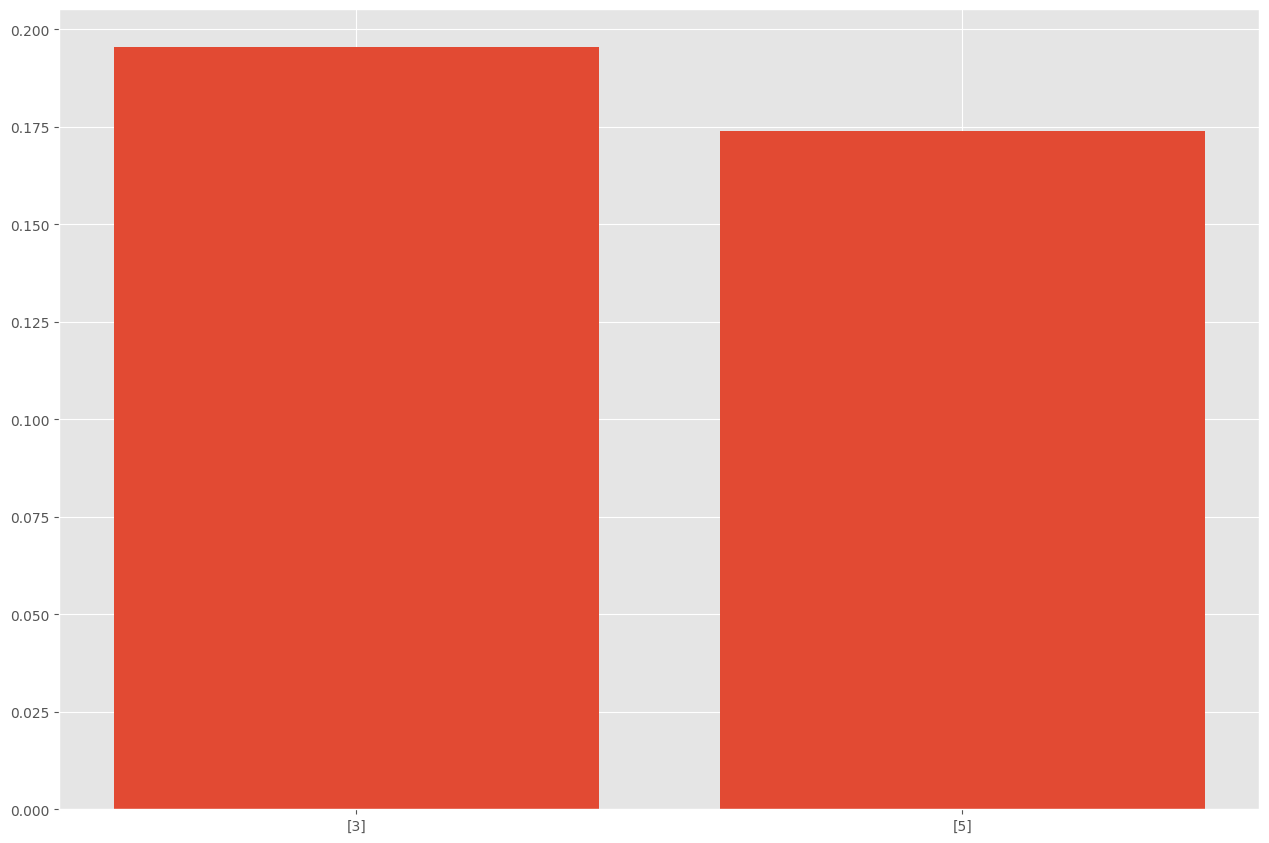

In [134]:
# plotting the fraction of deleted emails for various subject lengths.
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
lengths = ['[3]', '[5]']
deleted_fractions = [len(d_Three)/len(Three), len(d_Five)/len(Five)]
ax.bar(lengths, deleted_fractions)
plt.show()

## 02.04. Exploring the dataset

In [135]:
# moving lable to the end
df = df[[c for c in df if c not in ['Default']] + ['Default']]

In [29]:
df.head()

,GGGrade,Validation,Yearly_Income,Home_Status,Lend_Amount,Deprecatory_Records,Interest_Charged,Inquiries,Present_Balance,Gross_Collection,...,Reason,Due_Fee,Home0,Home1,Home2,Home3,Home4,Duration[3],Duration[5],Default
0,1,0,123200,0,10260,0,18.94,0,175923,0,...,12,0.0,0,0,0,0,0,1,1,0
1,1,0,255200,2,27916,0,13.27,1,628237,0,...,12,0.0,2,2,2,2,2,1,1,1
2,2,2,98842,1,14535,0,15.84,0,66999,0,...,12,0.0,1,1,1,1,1,1,1,0
3,2,0,149600,0,6840,0,21.80,0,471337,0,...,12,0.0,0,0,0,0,0,1,1,0
4,2,0,70400,0,10260,0,20.11,0,166497,0,...,12,0.0,0,0,0,0,0,1,1,0


Dataset size: 87499
Dataset shape: (87499, 24)


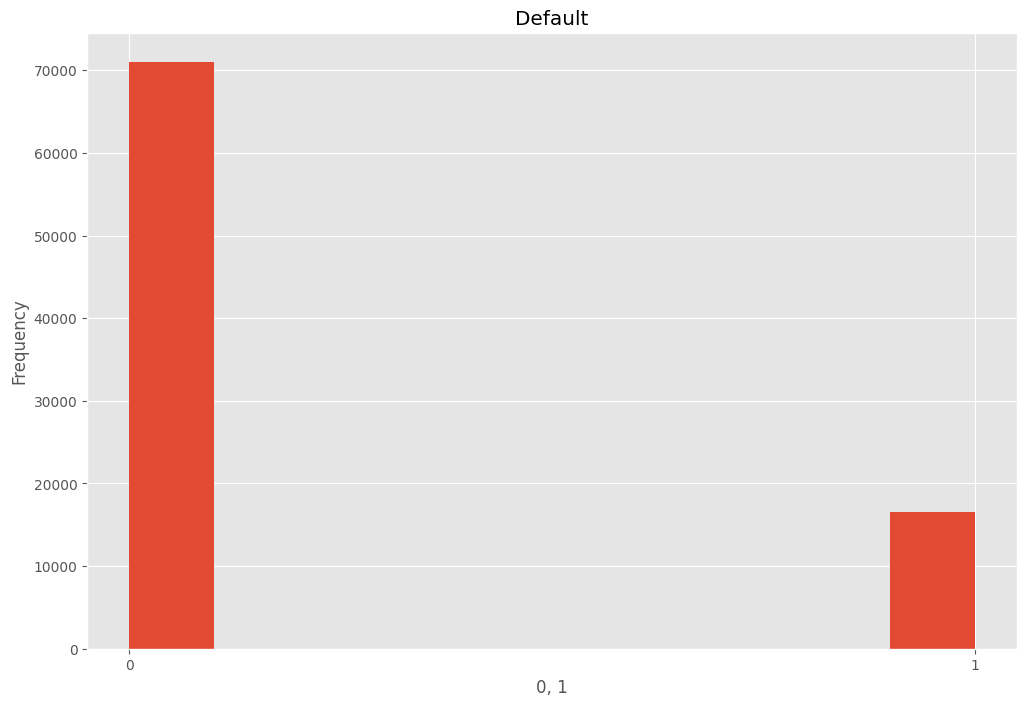

In [30]:
print("Dataset size:", len(df))
print("Dataset shape:", df.shape)
df['Default'].hist();
plt.title('Default')
plt.xlabel('0, 1')
plt.ylabel('Frequency')
plt.xticks([0,1]);

# 03. Logistic regression with Sci-kit learn and Bayesian Approach

In this section we build and compare several library classification models and we experiment with different feature sets.

## 03.01. Preparing Train/Test datasets

In [31]:
final_df = df

print(final_df.shape)
final_df.head()

(87499, 24)


,GGGrade,Validation,Yearly_Income,Home_Status,Lend_Amount,Deprecatory_Records,Interest_Charged,Inquiries,Present_Balance,Gross_Collection,...,Reason,Due_Fee,Home0,Home1,Home2,Home3,Home4,Duration[3],Duration[5],Default
0,1,0,123200,0,10260,0,18.94,0,175923,0,...,12,0.0,0,0,0,0,0,1,1,0
1,1,0,255200,2,27916,0,13.27,1,628237,0,...,12,0.0,2,2,2,2,2,1,1,1
2,2,2,98842,1,14535,0,15.84,0,66999,0,...,12,0.0,1,1,1,1,1,1,1,0
3,2,0,149600,0,6840,0,21.80,0,471337,0,...,12,0.0,0,0,0,0,0,1,1,0
4,2,0,70400,0,10260,0,20.11,0,166497,0,...,12,0.0,0,0,0,0,0,1,1,0


In [32]:
# shuffle
final_df = final_df.sample(frac=1).reset_index(drop=True)

In [33]:
print(final_df.shape)
final_df.head()

(87499, 24)


,GGGrade,Validation,Yearly_Income,Home_Status,Lend_Amount,Deprecatory_Records,Interest_Charged,Inquiries,Present_Balance,Gross_Collection,...,Reason,Due_Fee,Home0,Home1,Home2,Home3,Home4,Duration[3],Duration[5],Default
0,1,2,383680,0,41040,0,9.84,0,1434440,0,...,2,0.0,0,0,0,0,0,1,1,1
1,4,1,61600,1,17100,0,21.84,1,15999,0,...,1,0.0,1,1,1,1,1,1,1,0
2,2,1,0,0,25137,1,18.44,2,155285,0,...,1,0.0,0,0,0,0,0,1,1,0
3,4,2,619520,0,41040,0,17.73,1,988491,0,...,2,0.0,0,0,0,0,0,1,1,1
4,3,0,179520,2,30780,1,17.89,0,325889,0,...,2,0.0,2,2,2,2,2,0,0,0


In [34]:
# split train/test
train_perc = 0.7 # percentage of training data
split_point = int(train_perc*len(final_df))

df_train = final_df.iloc[:split_point,:]
df_test = final_df.iloc[split_point+1:,:]

print("train df:", df_train.shape)
print("test df: ", df_test.shape)

train df: (61249, 24)
test df:  (26249, 24)


## 03.02. Bayesian Classifier

In this starter model, we train a classifier using all the chosen features from the dataset

![LogReg](logreg.png)

![LogReg](logreg.png)

In [35]:
df_train.head()

,GGGrade,Validation,Yearly_Income,Home_Status,Lend_Amount,Deprecatory_Records,Interest_Charged,Inquiries,Present_Balance,Gross_Collection,...,Reason,Due_Fee,Home0,Home1,Home2,Home3,Home4,Duration[3],Duration[5],Default
0,1,2,383680,0,41040,0,9.84,0,1434440,0,...,2,0.0,0,0,0,0,0,1,1,1
1,4,1,61600,1,17100,0,21.84,1,15999,0,...,1,0.0,1,1,1,1,1,1,1,0
2,2,1,0,0,25137,1,18.44,2,155285,0,...,1,0.0,0,0,0,0,0,1,1,0
3,4,2,619520,0,41040,0,17.73,1,988491,0,...,2,0.0,0,0,0,0,0,1,1,1
4,3,0,179520,2,30780,1,17.89,0,325889,0,...,2,0.0,2,2,2,2,2,0,0,0


In [36]:
# train
mat_train = df_train[["GGGrade", "Validation", "Yearly_Income",
                      "Home_Status",	"Lend_Amount",	"Deprecatory_Records",
                      "Interest_Charged",	"Inquiries",  "Present_Balance",
                      "Gross_Collection", "Sub_GGGrade", "State", "Duration",
                      "Unpaid_Amount", "Reason", "Due_Fee", "Default"]].values
X_train = mat_train[:,:-1]
y_train = mat_train[:,-1].astype("int")
print("train x: {}, y: {}".format(X_train.shape, y_train.shape))

# test
mat_test = df_test[["GGGrade", "Validation", "Yearly_Income",
                      "Home_Status",	"Lend_Amount",	"Deprecatory_Records",
                      "Interest_Charged",	"Inquiries",  "Present_Balance",
                      "Gross_Collection", "Sub_GGGrade", "State", "Duration",
                      "Unpaid_Amount", "Reason", "Due_Fee", "Default"]].values
X_test = mat_test[:,0:-1]
y_test = mat_test[:,-1].astype("int")
print("test x: {}, y: {}".format(X_test.shape, y_test.shape))

train x: (61249, 16), y: (61249,)
test x: (26249, 16), y: (26249,)


In [37]:
X_train[0]

array([1.00000e+00, 2.00000e+00, 3.83680e+05, 0.00000e+00, 4.10400e+04,
       0.00000e+00, 9.84000e+00, 0.00000e+00, 1.43444e+06, 0.00000e+00,
       1.10000e+01, 4.00000e+00, 3.00000e+00, 1.20594e+05, 2.00000e+00,
       0.00000e+00])

In [38]:
# create and fit a baseline model
logreg = linear_model.LogisticRegression(solver='lbfgs', multi_class='auto', C=1)
logreg.fit(X_train, y_train)

# make predictions for test set
y_hat = logreg.predict(X_test)
print("predictions:", y_hat)
print("true values:", y_test)

# evaluate prediction accuracy
print("Accuracy:", 1.0*np.sum(y_hat == y_test) / len(y_test))

predictions: [0 0 0 ... 0 0 0]
true values: [0 0 0 ... 0 0 0]
Accuracy: 0.812145224579984


In [39]:
def model(X, obs=None):
    alpha = pyro.sample("alpha", dist.Normal(0, 5.).to_event()) # Prior for the bias/intercept
    beta  = pyro.sample("beta", dist.Normal(torch.zeros(X.shape[1]),
                                            5.*torch.ones(X.shape[1])).to_event()) # Priors for the regression coeffcients

    with pyro.plate("data"):
        logits = alpha + X.matmul(beta)
        y = pyro.sample("y", dist.Bernoulli(logits=logits), obs=obs)

    return y

In [40]:
# Prepare data for Pyro
X_train = X_train.astype(np.float64)
y_train = y_train.astype(np.int32)

X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).float()

In [41]:
X_train[0]

tensor([1.0000e+00, 2.0000e+00, 3.8368e+05, 0.0000e+00, 4.1040e+04, 0.0000e+00,
        9.8400e+00, 0.0000e+00, 1.4344e+06, 0.0000e+00, 1.1000e+01, 4.0000e+00,
        3.0000e+00, 1.2059e+05, 2.0000e+00, 0.0000e+00])

In [42]:
# Define guide function
guide = AutoMultivariateNormal(model)

# Reset parameter values
pyro.clear_param_store()

# Define the number of optimization steps
# n_steps = 30000
n_steps = 10000

# Setup the optimizer
adam_params = {"lr": 0.001}
optimizer = ClippedAdam(adam_params)

# Setup the inference algorithm
elbo = Trace_ELBO(num_particles=1)
svi = SVI(model, guide, optimizer, loss=elbo)

# Do gradient steps
for step in range(n_steps):
    elbo = svi.step(X_train, y_train)
    if step % 1000 == 0:
        print("[%d] ELBO: %.1f" % (step, elbo))

[0] ELBO: 16538585148.8
[1000] ELBO: 2119276480.9
[2000] ELBO: 1014062908.4
[3000] ELBO: 485265173.1
[4000] ELBO: 293164315.2
[5000] ELBO: 111040122.2
[6000] ELBO: 42687509.2
[7000] ELBO: 28511873.9
[8000] ELBO: 22187745.0
[9000] ELBO: 10109860.2


In [43]:
from pyro.infer import Predictive

predictive = Predictive(model, guide=guide, num_samples=2000,
                        return_sites=("alpha", "beta"))
samples = predictive(X_train, y_train)

In [44]:
alpha_hat = samples["alpha"].mean(axis=0).detach().numpy()
beta_hat = samples["beta"].mean(axis=0).detach().numpy()

In [45]:
# make predictions for test set
y_hat = alpha_hat + np.dot(X_test, beta_hat.T)
y_hat = np.squeeze(y_hat)
y_hat = (y_hat > 0).astype(int)

print("predictions:", y_hat)
print("true values:", y_test)

# evaluate prediction accuracy
acc_c_101 = 1.0*np.sum(y_hat == y_test) / len(y_test)
accuracies.append(acc_c_101)
print("Accuracy:", acc_c_101)

predictions: [0 0 0 ... 0 0 0]
true values: [0 0 0 ... 0 0 0]
Accuracy: 0.8095927463903386


## 03.03. Incorporating the bins

In this model, the bins are incorporated during the training process.

![LogReg with Bins](LogRegwBins.png)

In [46]:
# train
mat_train = df_train[["GGGrade", "Validation", "Yearly_Income",
                      "Home_Status",	"Lend_Amount",	"Deprecatory_Records",
                      "Interest_Charged",	"Inquiries",  "Present_Balance",
                      "Gross_Collection", "Sub_GGGrade", "State", "Duration",
                      "Unpaid_Amount", "Reason", "Due_Fee", "Home0",	"Home1",
                      "Home2", "Home3",	"Home4",	"Duration[3]", "Duration[5]", "Default"]].values
X_train = mat_train[:,0:-1]
y_train = mat_train[:,-1].astype("int")
print("train x: {}, y: {}".format(X_train.shape, y_train.shape))

# test
mat_test = df_test[["GGGrade", "Validation", "Yearly_Income",
                      "Home_Status",	"Lend_Amount",	"Deprecatory_Records",
                      "Interest_Charged",	"Inquiries",  "Present_Balance",
                      "Gross_Collection", "Sub_GGGrade", "State", "Duration",
                      "Unpaid_Amount", "Reason", "Due_Fee", "Home0",	"Home1",
                      "Home2", "Home3",	"Home4",	"Duration[3]", "Duration[5]", "Default"]].values
X_test = mat_test[:,:-1]
y_test = mat_test[:,-1].astype("int")
print("test x: {}, y: {}".format(X_test.shape, y_test.shape))

train x: (61249, 23), y: (61249,)
test x: (26249, 23), y: (26249,)


In [47]:
X_test[0]

array([3.00000e+00, 0.00000e+00, 1.05600e+05, 1.00000e+00, 2.22300e+04,
       0.00000e+00, 1.09900e+01, 0.00000e+00, 2.15296e+05, 0.00000e+00,
       2.10000e+01, 4.20000e+01, 3.00000e+00, 6.66700e+03, 1.20000e+01,
       0.00000e+00, 1.00000e+00, 1.00000e+00, 1.00000e+00, 1.00000e+00,
       1.00000e+00, 1.00000e+00, 1.00000e+00])

In [48]:
# create and fit a baseline model
logreg = linear_model.LogisticRegression(solver='lbfgs', multi_class='auto', C=1)
# print(X_train.shape[0])
print(X_train)
# X_train.reshape(X_train.shape[0], 1)
y_train.reshape(y_train.shape[0], 1)
# print(X_train.shape)
logreg.fit(X_train, y_train)

# make predictions for test set
y_hat = logreg.predict(X_test)
print("predictions:", y_hat)
print("true values:", y_test)

# evaluate prediction accuracy
print("Accuracy:", 1.0*np.sum(y_hat == y_test) / len(y_test))

[[1.0000e+00 2.0000e+00 3.8368e+05 ... 0.0000e+00 1.0000e+00 1.0000e+00]
 [4.0000e+00 1.0000e+00 6.1600e+04 ... 1.0000e+00 1.0000e+00 1.0000e+00]
 [2.0000e+00 1.0000e+00 0.0000e+00 ... 0.0000e+00 1.0000e+00 1.0000e+00]
 ...
 [4.0000e+00 1.0000e+00 1.6720e+05 ... 0.0000e+00 1.0000e+00 1.0000e+00]
 [2.0000e+00 0.0000e+00 1.4960e+05 ... 0.0000e+00 1.0000e+00 1.0000e+00]
 [2.0000e+00 1.0000e+00 1.4080e+05 ... 0.0000e+00 1.0000e+00 1.0000e+00]]
predictions: [0 0 0 ... 0 0 0]
true values: [0 0 0 ... 0 0 0]
Accuracy: 0.812145224579984


In [49]:
def model(X, obs=None):
    alpha = pyro.sample("alpha", dist.Normal(0, 5.).to_event()) # Prior for the bias/intercept
    beta  = pyro.sample("beta", dist.Normal(torch.zeros(X.shape[1]),
                                            5.*torch.ones(X.shape[1])).to_event()) # Priors for the regression coeffcients

    with pyro.plate("data"):
        logits = alpha + X.matmul(beta)
        y = pyro.sample("y", dist.Bernoulli(logits=logits), obs=obs)

    return y

In [50]:
# Prepare data for Pyro
X_train = X_train.astype(np.int32)
y_train = y_train.astype(np.int32)

X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).float()

In [51]:
# Define guide function
guide = AutoMultivariateNormal(model)

# Reset parameter values
pyro.clear_param_store()

# Define the number of optimization steps
# n_steps = 30000
n_steps = 10000

# Setup the optimizer
adam_params = {"lr": 0.001}
optimizer = ClippedAdam(adam_params)

# Setup the inference algorithm
elbo = Trace_ELBO(num_particles=1)
svi = SVI(model, guide, optimizer, loss=elbo)

# Do gradient steps
for step in range(n_steps):
    elbo = svi.step(X_train, y_train)
    if step % 1000 == 0:
        print("[%d] ELBO: %.1f" % (step, elbo))

[0] ELBO: 8746416206.6
[1000] ELBO: 1987343441.5
[2000] ELBO: 701024212.1
[3000] ELBO: 354757043.9
[4000] ELBO: 155868007.4
[5000] ELBO: 61461051.1
[6000] ELBO: 72746603.7
[7000] ELBO: 47030506.3
[8000] ELBO: 18902596.3
[9000] ELBO: 36397993.9


In [52]:
from pyro.infer import Predictive

predictive = Predictive(model, guide=guide, num_samples=2000,
                        return_sites=("alpha", "beta"))
samples = predictive(X_train, y_train)

In [53]:
alpha_hat = samples["alpha"].mean(axis=0).detach().numpy()
beta_hat = samples["beta"].mean(axis=0).detach().numpy()

In [54]:
# make predictions for test set
y_hat = alpha_hat + np.dot(X_test, beta_hat.T)
y_hat = np.squeeze(y_hat)
y_hat = (y_hat > 0).astype(int)

print("predictions:", y_hat)
print("true values:", y_test)

# evaluate prediction accuracy
acc_c_102 = 1.0*np.sum(y_hat == y_test) / len(y_test)
accuracies.append(acc_c_102)
print("Accuracy:", acc_c_102)

predictions: [0 0 1 ... 0 0 0]
true values: [0 0 0 ... 0 0 0]
Accuracy: 0.7633433654615414


## 03.04. Utilizing momemtum

In this model, we are making use of the

In [7]:
np.random.seed(42)

# load csv
df2 = pd.read_csv('Data_Train_AllNumbers.csv')
df2.head()

df2.describe()

mat = df2.values
mat

X = mat[:,0:-1]
print(X)
print(X.shape)

y = mat[:,-1].astype("int")
print(y)
print(y.shape)

[[1.0000e+00 0.0000e+00 1.2320e+05 ... 6.9700e+03 1.2000e+01 0.0000e+00]
 [1.0000e+00 0.0000e+00 2.5520e+05 ... 1.7461e+04 1.2000e+01 0.0000e+00]
 [2.0000e+00 2.0000e+00 9.8842e+04 ... 0.0000e+00 1.2000e+01 0.0000e+00]
 ...
 [6.0000e+00 2.0000e+00 9.1520e+04 ... 3.7759e+04 1.0000e+00 0.0000e+00]
 [3.0000e+00 0.0000e+00 3.1328e+05 ... 8.8400e+02 0.0000e+00 0.0000e+00]
 [6.0000e+00 2.0000e+00 7.5680e+04 ... 1.3541e+04 0.0000e+00 0.0000e+00]]
(87499, 16)
[0 1 0 ... 0 0 1]
(87499,)


In [8]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(sparse=False)
X = encoder.fit_transform(X)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [9]:
# descriptive statistics
df2.describe()

# data preparation
mat = df2.values
mat

X = mat[:,0:-1]
print(X)
print(X.shape)

y = mat[:,-1].astype("int")
print(y)
print(y.shape)

train_perc = 0.66 # percentage of training data
split_point = int(train_perc*len(y))
perm = np.random.permutation(len(y)) # we also randomize the dataset
ix_train = perm[:split_point]
ix_test = perm[split_point:]
X_train = X[ix_train,:]
print(X_train)
X_test = X[ix_test,:]
y_train = y[ix_train]
print(y_train)
y_test = y[ix_test]
print("num train: %d" % len(y_train))
print("num test: %d" % len(y_test))

[[1.0000e+00 0.0000e+00 1.2320e+05 ... 6.9700e+03 1.2000e+01 0.0000e+00]
 [1.0000e+00 0.0000e+00 2.5520e+05 ... 1.7461e+04 1.2000e+01 0.0000e+00]
 [2.0000e+00 2.0000e+00 9.8842e+04 ... 0.0000e+00 1.2000e+01 0.0000e+00]
 ...
 [6.0000e+00 2.0000e+00 9.1520e+04 ... 3.7759e+04 1.0000e+00 0.0000e+00]
 [3.0000e+00 0.0000e+00 3.1328e+05 ... 8.8400e+02 0.0000e+00 0.0000e+00]
 [6.0000e+00 2.0000e+00 7.5680e+04 ... 1.3541e+04 0.0000e+00 0.0000e+00]]
(87499, 16)
[0 1 0 ... 0 0 1]
(87499,)
[[2.00000e+00 0.00000e+00 7.92000e+04 ... 7.65600e+03 2.00000e+00
  0.00000e+00]
 [5.00000e+00 2.00000e+00 5.72000e+04 ... 0.00000e+00 2.00000e+00
  0.00000e+00]
 [5.00000e+00 1.00000e+00 1.37280e+05 ... 6.59400e+03 2.00000e+00
  0.00000e+00]
 ...
 [2.00000e+00 0.00000e+00 2.63731e+05 ... 3.16080e+04 2.00000e+00
  0.00000e+00]
 [4.00000e+00 2.00000e+00 8.80000e+04 ... 1.61370e+04 2.00000e+00
  0.00000e+00]
 [6.00000e+00 2.00000e+00 9.68000e+04 ... 0.00000e+00 2.00000e+00
  0.00000e+00]]
[0 0 0 ... 0 0 0]
num tra

In [10]:
# using sklearn first

# logistic regression model
logreg = linear_model.LogisticRegression(solver='lbfgs', multi_class='auto', C=1)
logreg.fit(X_train, y_train)

# make predictions for test set
y_hat = logreg.predict(X_test)
print("predictions:", y_hat)
print("true values:", y_test)

# evaluate prediction accuracy
print("Accuracy:", 1.0*np.sum(y_hat == y_test) / len(y_test))

predictions: [0 0 0 ... 0 0 0]
true values: [0 0 0 ... 0 0 0]
Accuracy: 0.8111596638655462


In [11]:
# pyro
def model(X, n_cat, obs=None):
    input_dim = X.shape[1]
    alpha = pyro.sample("alpha", dist.Normal(torch.zeros(1, n_cat),
                                             5.*torch.ones(1, n_cat)).to_event())  # Prior for the bias/intercept
    beta  = pyro.sample("beta", dist.Normal(torch.zeros(input_dim, n_cat),
                                            5.*torch.ones(input_dim, n_cat)).to_event()) # Priors for the regression coeffcients

    with pyro.plate("data"):
        y = pyro.sample("y", dist.Categorical(logits=alpha + X.matmul(beta)), obs=obs)

    return y

n_cat = 2
# Prepare data for Pyro
X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).float()

In [12]:
# Prepare data for Pyro
# X_train = X_train.astype(np.float64)
# y_train = y_train.astype(np.int32)

X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).float()

<ipython-input-12-e6dc06c67fcf>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train = torch.tensor(X_train).float()
<ipython-input-12-e6dc06c67fcf>:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y_train).float()


In [13]:
X_train[0]

tensor([2.0000e+00, 0.0000e+00, 7.9200e+04, 1.0000e+00, 1.0175e+04, 0.0000e+00,
        8.3200e+00, 0.0000e+00, 3.9689e+04, 0.0000e+00, 1.9000e+01, 4.0000e+00,
        3.0000e+00, 7.6560e+03, 2.0000e+00, 0.0000e+00])

In [30]:
# Define guide function
guide = AutoMultivariateNormal(model)

# Reset parameter values
pyro.clear_param_store()

# Define the number of optimization steps
# n_steps = 40000
n_steps = 10000

# Setup the optimizer
adam_params = {"lr": 0.001, "betas": (0.9, 0.999)}  # Added betas for momentum
optimizer = ClippedAdam(adam_params)

# Setup the inference algorithm
elbo = Trace_ELBO(num_particles=1)
svi = SVI(model, guide, optimizer, loss=elbo)

# Do gradient steps
for step in range(n_steps):
    elbo = svi.step(X_train, n_cat, y_train)
    if step % 1000 == 0:
        print("[%d] ELBO: %.1f" % (step, elbo))

[0] ELBO: 891463281.7
[1000] ELBO: 406754135.6
[2000] ELBO: 303357096.2
[3000] ELBO: 80824699.5
[4000] ELBO: 172266692.0
[5000] ELBO: 66544383.7
[6000] ELBO: 50009928.3
[7000] ELBO: 61477913.7
[8000] ELBO: 72050405.7
[9000] ELBO: 27673539.9


In [31]:
from pyro.infer import Predictive

predictive = Predictive(model, guide=guide, num_samples=2000,
                        return_sites=("alpha", "beta"))
samples = predictive(X_train, n_cat, y_train-1)

In [32]:
samples_alpha = samples["alpha"].detach().squeeze()
samples_beta = samples['beta'].detach().squeeze()

In [33]:
alpha_hat = samples_alpha.mean(axis=0).numpy()
beta_hat = samples_beta.mean(axis=0).numpy()

In [34]:
# make predictions for test set
y_hat = alpha_hat + np.dot(X_test, beta_hat)
y_hat = np.argmax(y_hat, axis=1)
print("predictions:", y_hat)
print("true values:", y_test)

# evaluate prediction accuracy
acc_c_103 = 1.0*np.sum(y_hat == y_test) / len(y_test)
accuracies.append(acc_c_103)
print("Accuracy:", acc_c_103)

predictions: [0 0 0 ... 0 0 0]
true values: [0 0 0 ... 0 0 0]
Accuracy: 0.7781848739495798


# 04. Hierarchal Classification

## 04.01. Prepare Dataset

We need to add a unique integer identifier for every individual to be used in the hierarchal model.

In [65]:
final_df.head()

,GGGrade,Validation,Yearly_Income,Home_Status,Lend_Amount,Deprecatory_Records,Interest_Charged,Inquiries,Present_Balance,Gross_Collection,...,Reason,Due_Fee,Home0,Home1,Home2,Home3,Home4,Duration[3],Duration[5],Default
0,1,2,383680,0,41040,0,9.84,0,1434440,0,...,2,0.0,0,0,0,0,0,1,1,1
1,4,1,61600,1,17100,0,21.84,1,15999,0,...,1,0.0,1,1,1,1,1,1,1,0
2,2,1,0,0,25137,1,18.44,2,155285,0,...,1,0.0,0,0,0,0,0,1,1,0
3,4,2,619520,0,41040,0,17.73,1,988491,0,...,2,0.0,0,0,0,0,0,1,1,1
4,3,0,179520,2,30780,1,17.89,0,325889,0,...,2,0.0,2,2,2,2,2,0,0,0


In [66]:
sstates = [sstates for sstates in final_df['State'].unique()]
final_df['ind'] = final_df.apply(lambda row: sstates.index(row['State']) + 1, axis = 1)
final_df = final_df[[c for c in final_df if c not in ['Default']] + ['Default']]
ind_column = final_df.pop('ind')
final_df.insert(1, 'ind', ind_column)

In [67]:
final_df.head()

,GGGrade,ind,Validation,Yearly_Income,Home_Status,Lend_Amount,Deprecatory_Records,Interest_Charged,Inquiries,Present_Balance,...,Reason,Due_Fee,Home0,Home1,Home2,Home3,Home4,Duration[3],Duration[5],Default
0,1,1,2,383680,0,41040,0,9.84,0,1434440,...,2,0.0,0,0,0,0,0,1,1,1
1,4,2,1,61600,1,17100,0,21.84,1,15999,...,1,0.0,1,1,1,1,1,1,1,0
2,2,3,1,0,0,25137,1,18.44,2,155285,...,1,0.0,0,0,0,0,0,1,1,0
3,4,4,2,619520,0,41040,0,17.73,1,988491,...,2,0.0,0,0,0,0,0,1,1,1
4,3,5,0,179520,2,30780,1,17.89,0,325889,...,2,0.0,2,2,2,2,2,0,0,0


In [68]:
# split train/test
train_perc = 0.7 # percentage of training data
split_point = int(train_perc*len(final_df))

df_train = final_df.iloc[:split_point,:]
df_test = final_df.iloc[split_point+1:,:]

print("train df:", df_train.shape)
print("test df: ", df_test.shape)

train df: (61249, 25)
test df:  (26249, 25)


## 04.02. Hierarchical Bayesian model

In this section, we are building a hierarchical bayesian model with all the selected attributes.

![MCMC](MCMC.png)

In [69]:
# train
mat_train = df_train.values
X_train = mat_train[:,:-9]
y_train = mat_train[:,-1].astype("int")
ind_train = mat_train[:,0].astype("int")
print("train x: {}, y: {}, ind: {}".format(X_train.shape, y_train.shape, ind_train.shape))

# test
mat_test = df_test.values
X_test = mat_test[:,:-9]
y_test = mat_test[:,-1].astype("int")
ind_test = mat_test[:,0].astype("int")
print("test x: {}, y: {}, ind: {}".format(X_test.shape, y_test.shape, ind_test.shape))

train x: (61249, 16), y: (61249,), ind: (61249,)
test x: (26249, 16), y: (26249,), ind: (26249,)


In [70]:
def hierarchical_model(X, ind, n_ind, obs=None):
    input_dim = X.shape[1]

    alpha_mu = pyro.sample("alpha_mu", dist.Normal(0, 10.).to_event()) # Prior for the bias mean
    alpha_sigma  = pyro.sample("alpha_sigma",  dist.HalfCauchy(10.).to_event()) # Prior for the bias standard deviation

    beta  = pyro.sample("beta", dist.Normal(torch.zeros(input_dim), 10.*torch.ones(input_dim)).to_event())

    with pyro.plate("ind", n_ind):
        alpha = pyro.sample("alpha", dist.Normal(alpha_mu, alpha_sigma).to_event())

    with pyro.plate("data", X.shape[0]):
        logits = alpha[ind] + X.matmul(beta)
        y = pyro.sample("y", dist.Bernoulli(logits=logits), obs=obs)

    return y

In [71]:
X_train = X_train.astype(np.float64)
y_train = y_train.astype(np.int32)

In [72]:
X_train[0]

array([1.00000e+00, 1.00000e+00, 2.00000e+00, 3.83680e+05, 0.00000e+00,
       4.10400e+04, 0.00000e+00, 9.84000e+00, 0.00000e+00, 1.43444e+06,
       0.00000e+00, 1.10000e+01, 4.00000e+00, 3.00000e+00, 1.20594e+05,
       2.00000e+00])

In [73]:
# Prepare data for Pyro model
n_ind = ind_train.max()
X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).float()
ind_train = torch.tensor(ind_train).long() # these are indices, therefore they need to be (long) integers

In [74]:
X_train.shape, n_ind

(torch.Size([61249, 16]), 49)

In [75]:
%%time

nuts_kernel = NUTS(hierarchical_model)
mcmc = MCMC(nuts_kernel, num_samples=500, warmup_steps=100, num_chains=1)
mcmc.run(X_train, ind_train-1, n_ind, y_train)

Sample: 100%|██████████| 200/200 [13:34,  4.07s/it, step size=3.93e-10, acc. prob=0.785]

CPU times: user 13min 8s, sys: 1.89 s, total: 13min 10s
Wall time: 13min 34s


In [76]:
samples = mcmc.get_samples()
beta_samples = samples["beta"].detach().numpy()
alpha_samples = samples["alpha"].detach().numpy()
alpha_mu_samples = samples["alpha_mu"].detach().numpy()
alpha_sigma_samples = samples["alpha_sigma"].detach().numpy()

In [77]:
# extract expected values of the parameters
alpha_hat = samples["alpha"].mean(axis=0).detach().numpy()
beta_hat = samples["beta"].mean(axis=0).detach().numpy()

In [78]:
# make predictions for test set
y_hat = alpha_hat[ind_test-1] + np.dot(X_test, beta_hat.T)
y_hat = np.squeeze(y_hat)
y_hat = (y_hat > 0).astype(int)

print("predictions:", y_hat)
print("true values:", y_test)

# evaluate prediction accuracy
acc_c_201 = 1.0*np.sum(y_hat == y_test) / len(y_test)
accuracies.append(acc_c_201)
print("Accuracy:", acc_c_201)

predictions: [1 0 1 ... 0 0 1]
true values: [0 0 0 ... 0 0 0]
Accuracy: 0.6473389462455713


## 04.03. Incorporating the Bins

The bins are incorporated in this model.

![MCMC with Bins](MCMCwBins.png)

In [136]:
# train
mat_train = df_train.values
X_train = mat_train[:,:-1]
y_train = mat_train[:,-1].astype("int")
ind_train = mat_train[:,0].astype("int")
print("train x: {}, y: {}, ind: {}".format(X_train.shape, y_train.shape, ind_train.shape))

# test
mat_test = df_test.values
X_test = mat_test[:,:-1]
y_test = mat_test[:,-1].astype("int")
ind_test = mat_test[:,0].astype("int")
print("test x: {}, y: {}, ind: {}".format(X_test.shape, y_test.shape, ind_test.shape))

train x: (61249, 24), y: (61249,), ind: (61249,)
test x: (26249, 24), y: (26249,), ind: (26249,)


In [137]:
def hierarchical_model(X, ind, n_ind, obs=None):
    input_dim = X.shape[1]

    alpha_mu = pyro.sample("alpha_mu", dist.Normal(0, 10.).to_event()) # Prior for the bias mean
    alpha_sigma  = pyro.sample("alpha_sigma",  dist.HalfCauchy(10.).to_event()) # Prior for the bias standard deviation

    beta  = pyro.sample("beta", dist.Normal(torch.zeros(input_dim), 10.*torch.ones(input_dim)).to_event())

    with pyro.plate("ind", n_ind):
        alpha = pyro.sample("alpha", dist.Normal(alpha_mu, alpha_sigma).to_event())

    with pyro.plate("data", X.shape[0]):
        logits = alpha[ind] + X.matmul(beta)
        y = pyro.sample("y", dist.Bernoulli(logits=logits), obs=obs)

    return y

In [138]:
X_train = X_train.astype(np.float64)
y_train = y_train.astype(np.int32)

In [139]:
X_train[0]

array([1.00000e+00, 1.00000e+00, 2.00000e+00, 3.83680e+05, 0.00000e+00,
       4.10400e+04, 0.00000e+00, 9.84000e+00, 0.00000e+00, 1.43444e+06,
       0.00000e+00, 1.10000e+01, 4.00000e+00, 3.00000e+00, 1.20594e+05,
       2.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
       0.00000e+00, 0.00000e+00, 1.00000e+00, 1.00000e+00])

In [140]:
# Prepare data for Pyro model
n_ind = ind_train.max()
X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).float()
ind_train = torch.tensor(ind_train).long() # these are indices, therefore they need to be (long) integers

In [141]:
X_train.shape, n_ind

(torch.Size([61249, 24]), 7)

In [142]:
%%time

nuts_kernel = NUTS(hierarchical_model)
mcmc = MCMC(nuts_kernel, num_samples=500, warmup_steps=100, num_chains=1)
mcmc.run(X_train, ind_train-1, n_ind, y_train)

Sample: 100%|██████████| 600/600 [49:49,  4.98s/it, step size=1.67e-10, acc. prob=0.731]

CPU times: user 48min 32s, sys: 7.01 s, total: 48min 39s
Wall time: 49min 49s


In [151]:
samples = mcmc.get_samples()
beta_samples = samples["beta"].detach().numpy()
alpha_samples = samples["alpha"].detach().numpy()
alpha_mu_samples = samples["alpha_mu"].detach().numpy()
alpha_sigma_samples = samples["alpha_sigma"].detach().numpy()

<ipython-input-121-b89e9b13d540>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(alpha_mu_samples)


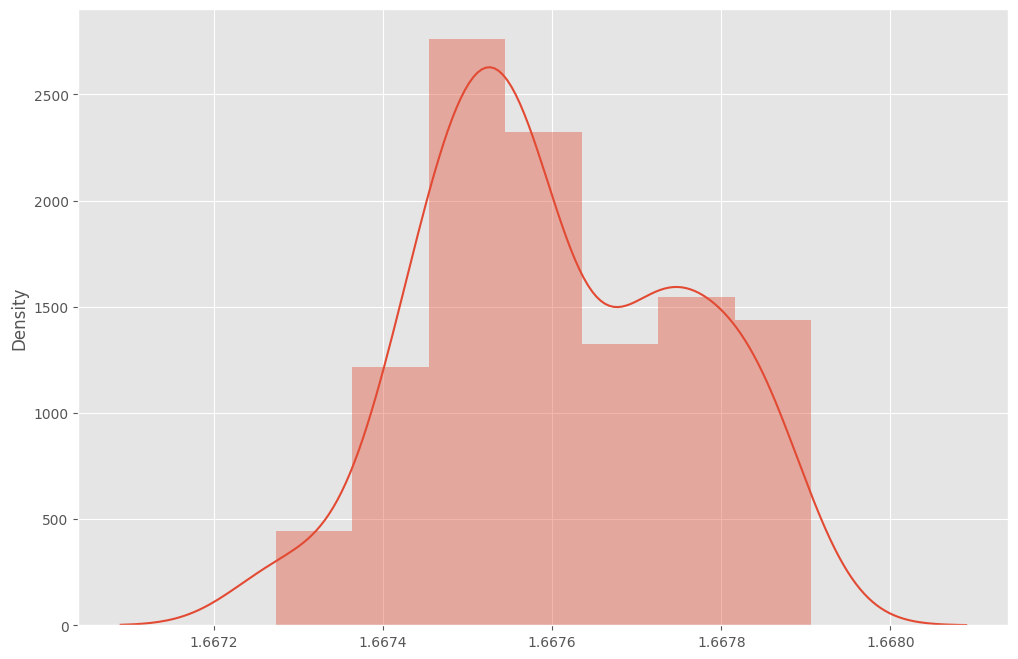

In [ ]:
sns.distplot(alpha_mu_samples)
plt.show()

<ipython-input-122-94fc6457b447>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(alpha_sigma_samples)


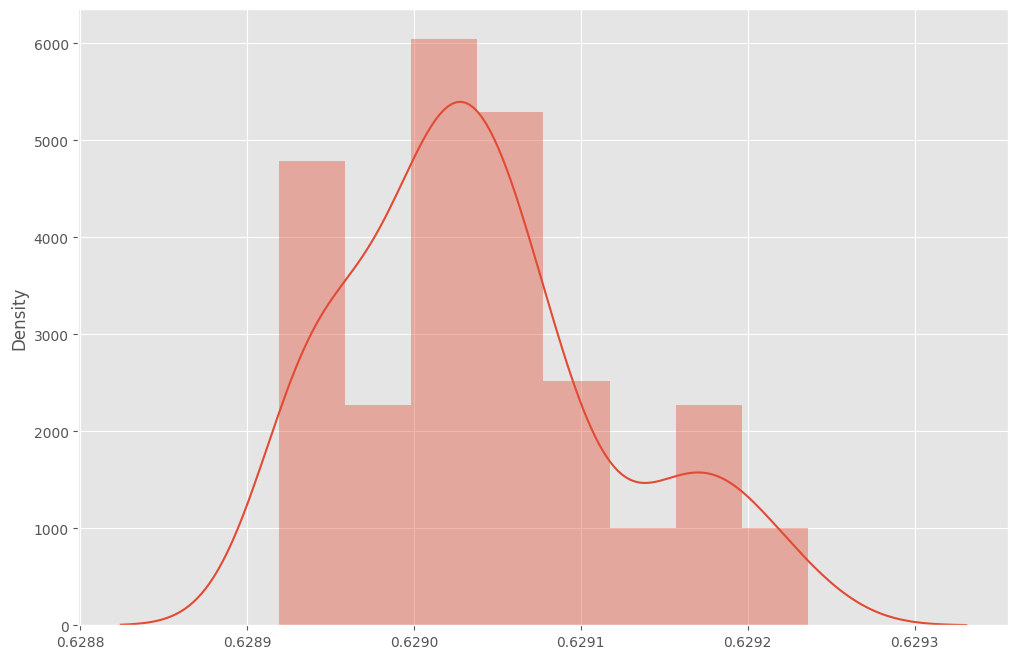

In [ ]:
sns.distplot(alpha_sigma_samples)
plt.show()

In [154]:
# extract expected values of the parameters
alpha_hat = samples["alpha"].mean(axis=0).detach().numpy()
beta_hat = samples["beta"].mean(axis=0).detach().numpy()

In [155]:
# make predictions for test set
y_hat = alpha_hat[ind_test-1] + np.dot(X_test, beta_hat.T)
y_hat = np.squeeze(y_hat)
y_hat = (y_hat > 0).astype(int)

print("predictions:", y_hat)
print("true values:", y_test)

# evaluate prediction accuracy
acc_c_202 = 1.0*np.sum(y_hat == y_test) / len(y_test)
accuracies.append(acc_c_202)
print("Accuracy:", acc_c_202)

predictions: [0 0 0 ... 0 0 0]
true values: [0 0 0 ... 0 0 0]
Accuracy: 0.732904110632786


## 05. Gradient Boosting Classifier model

In [121]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, accuracy_score

In [156]:
# Load the dataset
df = pd.read_csv('Data_Train_AllNumbers.csv')

# Prepare the data
X = df.drop('Default', axis=1)
y = df['Default']

# Split the dataset into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [157]:
# Train the Gradient Boosting Classifier
gbm = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
gbm.fit(X_train, y_train)

GradientBoostingClassifier(random_state=42)

In [124]:
# Validate the model using train-test split
predictions = gbm.predict(X_val)
accuracy = accuracy_score(y_val, predictions)
print(f"Validation Accuracy: {accuracy}")
acc_c_301 = accuracy

# Evaluate the model using k-fold cross-validation
scores = cross_val_score(gbm, X, y, cv=5, scoring='accuracy')
print(f"Cross-Validation Scores: {scores}")
print(f"Average Cross-Validation Score: {scores.mean()}")

# Classification report
report = classification_report(y_val, predictions)
print("Classification Report:\n", report)

Validation Accuracy: 0.8110285714285714
Cross-Validation Scores: [0.18925714 0.63011429 0.53822857 0.81125714 0.81124636]
Average Cross-Validation Score: 0.596020699958365
Classification Report:
               precision    recall  f1-score   support

           0       0.81      1.00      0.90     14195
           1       0.25      0.00      0.00      3305

    accuracy                           0.81     17500
   macro avg       0.53      0.50      0.45     17500
weighted avg       0.71      0.81      0.73     17500



# 06. Comparing Results

In [38]:
# reconstruct the list again, in case of multiple runs
accuracies = []
accuracies.append(acc_c_101)
accuracies.append(acc_c_102)
accuracies.append(acc_c_103)
accuracies.append(acc_c_201)
accuracies.append(acc_c_202)
accuracies.append(acc_c_301)

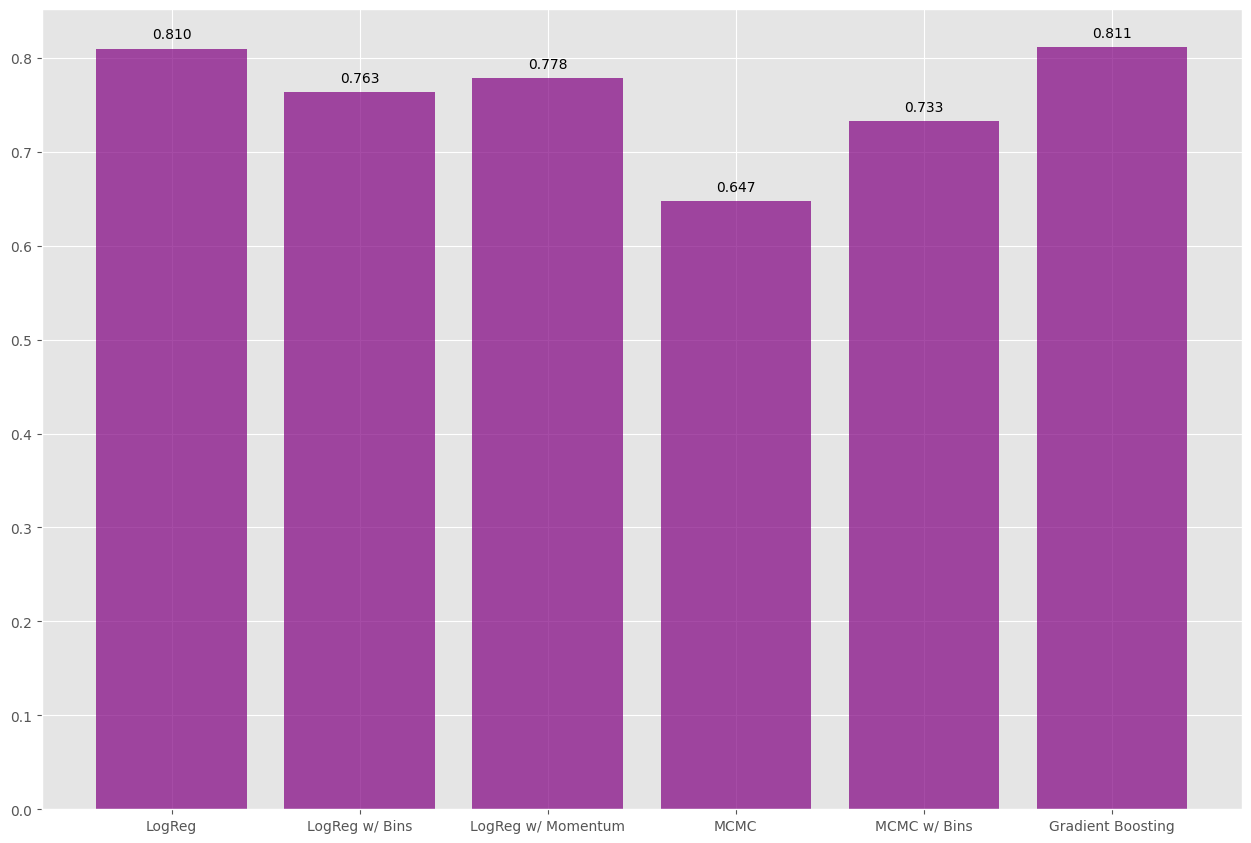

In [39]:
# plotting the accuracy of all the models
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
labels = ['LogReg', 'LogReg w/ Bins', 'LogReg w/ Momentum', 'MCMC', 'MCMC w/ Bins', 'Gradient Boosting']
ax.bar(labels, accuracies, color='purple', alpha=0.7)

def add_value_labels(ax, spacing=5):
    """Add labels to the end of each bar in a bar chart."""
    for rect in ax.patches:
        y_value = rect.get_height()
        x_value = rect.get_x() + rect.get_width() / 2
        space = spacing
        va = 'bottom'
        if y_value < 0:
            # In case the bar chart is "inverted"
            space *= -1
            va = 'top'
        label = "{:.3f}".format(y_value)
        ax.annotate(label, (x_value, y_value),
                    xytext=(0, space),
                    textcoords="offset points",
                    ha='center', va=va)

add_value_labels(ax)
plt.show()